In [1]:
# comparison of splines to other datasets:
# - in the transect (AWIPIES from geoslurp database)
# https://github.com/FESOM/pyfesom/blob/master/notebooks/plot_transect.ipynb
# - visualize as T/S trend (trend for every level and point, coestimate annual and semiannual, maybe smth else? use uncertainties)
# - time period: 01.2007-12.2016?
# - visualize as trend of steric height

# https://icdc.cen.uni-hamburg.de/en/ishii.html
# https://icdc.cen.uni-hamburg.de/en/en4.html

In [2]:
import sys
sys.path.append("../")

import numpy as np
import numpy.matlib
import math
import matplotlib.pyplot as plt
from geopy import distance
import pyfesom as pf
import scipy.io
from netCDF4 import *
import julian
import datetime
from datetime import timedelta
import paramTSz as func
from matplotlib import cm
%matplotlib inline

In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/najona/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

In [3]:
# EN4 data
ds = Dataset('EN.4.2.1.f.profiles.g10.201901.nc')
    
# temperature (in degC)
T = ds.variables['TEMP'][:]

# practical salinity
PSAL = ds.variables['PSAL_CORRECTED'][:]

# depth
depth = ds.variables['DEPH_CORRECTED'][:]

# julian day of the profile (JULD:units = "days since 1950-01-01 00:00:00 UTC")
t = ds.variables['JULD'][:]
date_ref = datetime.datetime.strptime('1950-01-01 00:00:00', "%Y-%m-%d %H:%M:%S")
jd_ref = julian.to_jd(date_ref, fmt='jd')
time = np.array([julian.from_jd(t[i] + jd_ref) for i in range(len(t))])
    
lat = ds.variables['LATITUDE'][:]
long = ds.variables['LONGITUDE'][:]

# read bottom pressure data (https://github.com/strawpants/schroeter-southatlantic-2019/tree/master/analysis/data)
dataOBP = scipy.io.loadmat('OBPv2.mat')
degE = dataOBP['degE'] 
degN = dataOBP['degN'] 
P_oc = dataOBP['OPRES']
time = dataOBP['OTIME']

In [4]:
basedir = '/home/najona/swift.dkrz.de'

# load the mesh
meshpath  = basedir+'/COREII/'
mesh = pf.load_mesh(meshpath, usepickle=True)

/home/najona/swift.dkrz.de/COREII/pickle_mesh_py3
3
The usepickle == True)
The pickle file for python 3 exists.
The mesh will be loaded from /home/najona/swift.dkrz.de/COREII/pickle_mesh_py3


In [5]:
# load data for one year
fl = Dataset(basedir+'/COREII_data/fesom.1951.oce.mean.nc')
fl.variables['temp'].shape

(12, 3668773)

In [6]:
# select one month
data = fl.variables['temp'][0,:]

In [7]:
lon_start = np.min(degE) 
lat_start = np.min(degN) 
lon_end   = np.max(degE) 
lat_end   = np.max(degN) 

npoints = 80

In [8]:
lonlat = pf.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end, npoints=npoints)
labeles = [str(abs(int(x)))+"$^{\circ}$S" for x in lonlat[7::8][:,1]]
dist = pf.transect_get_distance(lonlat) # gets distances between starting point and present point

### Interpolate T,S at the bottom pressure locations

In [9]:
# Merge most similar Temperature/Salinity measurements in a cluster
# plt.figure(figsize=(10,5))
# plt.ylim([-70,-30])
# plt.xlim([-15,30])
# plt.plot(long, lat, '.')
for i in range(len(degE)):
    idx_T, cluster_T, lat_cluster_T, long_cluster_T = func.clustering(lat, long, degN[i], degE[i], T[:,0], 3) # Temperature
    idx_S, cluster_S, lat_cluster_S, long_cluster_S = func.clustering(lat, long, degN[i], degE[i], PSAL[:,0], 1) # Salinity
#     plt.plot(long_cluster_T, lat_cluster_T, '.')
    globals()["T_all_cluster_" + str(i)] = np.array(T[list(idx_T.astype(int)),:]) # Temperature
    globals()["T_depth_cluster_" + str(i)] = np.array(depth[list(idx_T.astype(int)),:])
    
    globals()["S_all_cluster_" + str(i)] = np.array(PSAL[list(idx_S.astype(int)),:]) # Salinity
    globals()["S_depth_cluster_" + str(i)] = np.array(depth[list(idx_S.astype(int)),:])
# plt.plot(degE, degN, 'k.')
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")      
# plt.show()

In [10]:
# Approximation of T,S at the bottom pressure locations => cubic b-splines
rms_S = []
rms_T = []
for j in range(len(degE)):
    # get all T/S and z values belonging to a cluster
    T_depth_cluster = globals()["T_depth_cluster_" + str(j)] 
    T_cluster = globals()["T_all_cluster_" + str(j)]
    
    S_depth_cluster = globals()["S_depth_cluster_" + str(j)]
    S_cluster = globals()["S_all_cluster_" + str(j)]
    
    # reshape matrices in a vector
    T_new = T_cluster.ravel()
    T_depth_new = T_depth_cluster.ravel()
    S_new = S_cluster.ravel()
    S_depth_new = S_depth_cluster.ravel()
    
    T_depth_new = T_depth_new[T_depth_new != 99999] # delete masked values (=999999)
    T_new = T_new[T_new != 99999]
    S_depth_new = S_depth_new[S_depth_new != 99999]
    S_new = S_new[S_new != 99999]
    
    S_depth_sort = np.sort(S_depth_new) # sort the depth values
    T_depth_sort = np.sort(T_depth_new)
    S_new_ = S_new[np.argsort(S_depth_new)] # sort T/S in corresponding order
    T_new_ = T_new[np.argsort(T_depth_new)]
    
    #-----------------------------equidistant points
    # node distance
#     dkappa_T = 400
#     dkappa_S = 400
#     dkappa_T = ceil(np.max(T_depth_new)/5)
#     dkappa_S = ceil(np.max(S_depth_new)/5)

#     # nodes
#     kappa_x_T = np.arange(0, ceil(np.max(T_depth_new)/dkappa_T)*dkappa_T + dkappa_T, dkappa_T)
#     kappa_x_S = np.arange(0, ceil(np.max(S_depth_new)/dkappa_S)*dkappa_S + dkappa_S, dkappa_S)
    #-------------------------------
    
    #-------------------------------distance depending on T/S gradient
    kappa_x_T = np.array((0, 50, 100, 150, 200, 1000, np.max(T_depth_sort)))
    dkappa_T = 2000 
    
    kappa_x_S = np.array((0, 50, 100, 150, 200, 1000, np.max(S_depth_sort)))
    dkappa_S = 2000 

    #-------------------------------
    
    # get designmatrices
    A_T = func.getA(kappa_x_T, dkappa_T, T_depth_sort)
    A_S = func.getA(kappa_x_S, dkappa_S, S_depth_sort)
    
    xS_T,lS_T,v_T,rp_T = func.linearGMM(A_T, T_new_)
    xS_S,lS_S,v_S,rp_S = func.linearGMM(A_S, S_new_)
    
    rms_S.append(np.sqrt(np.mean(np.square(v_S))))
    rms_T.append(np.sqrt(np.mean(np.square(v_T))))
    
    #-------------------------- Evaluation of the functions on an equidistant grid
    t_Raster_S = np.arange(0, np.max(S_depth_sort), (np.max(S_depth_sort)-np.min(S_depth_sort))/10000) # vector with equidistant values
    t_Raster_T = np.arange(0, np.max(T_depth_sort), (np.max(T_depth_sort)-np.min(T_depth_sort))/10000)
    
    Ax_S = func.getA(kappa_x_S, dkappa_S, t_Raster_S)
    Ax_T = func.getA(kappa_x_T, dkappa_T, t_Raster_T)

    f_Raster_S = Ax_S.dot(xS_S)
    f_Raster_T = Ax_T.dot(xS_T)
    globals()["T_point_" + str(j)] = f_Raster_T
    globals()["depthT_point_" + str(j)] = t_Raster_T
    #--------------------------
    
#     cluster = plt.figure(figsize=(10,5))
#     plt.subplot(211)
#     print("Cluster", str(j), ", # parameters (T) = ", xS_T.shape)
#     plt.title('Cluster '+str(j)+', at bottom pressure location: lat = '+str(np.round(degE[j],2))+'°'+', long = '+str(np.round(degN[j],2))+'°')
#     for i in range(len(T_depth_cluster)):
#         plt.plot(T_depth_cluster[i,:], T_cluster[i,:], '.')
#         plt.xlim([np.min(T_depth_cluster), np.max(T_depth_cluster[T_depth_cluster != 99999])])
#         plt.ylim([np.min(T_cluster), np.max(T_cluster[T_cluster != 99999])])
#         plt.xlabel("Depth [m]")
#         plt.ylabel("Temperature [°C]")
#     plt.plot(t_Raster_T, f_Raster_T, 'k')
    
#     plt.subplot(212)
#     print("Cluster", str(j), ", # parameters (S) = ", xS_S.shape)
#     for i in range(len(S_depth_cluster)):
#         plt.plot(S_depth_cluster[i,:], S_cluster[i,:], '.')
#         plt.xlim([np.min(S_depth_cluster), np.max(S_depth_cluster[S_depth_cluster != 99999])])
#         plt.ylim([np.min(S_cluster[S_cluster >= 30]), np.max(S_cluster[S_cluster != 99999])])
#         plt.xlabel("Depth [m]")
#         plt.ylabel("Salinity")
#     plt.plot(t_Raster_S, f_Raster_S, 'k')
#     plt.show()
    #cluster.savefig('cluster'+str(j)+'.png', bbox_inches='tight')
    

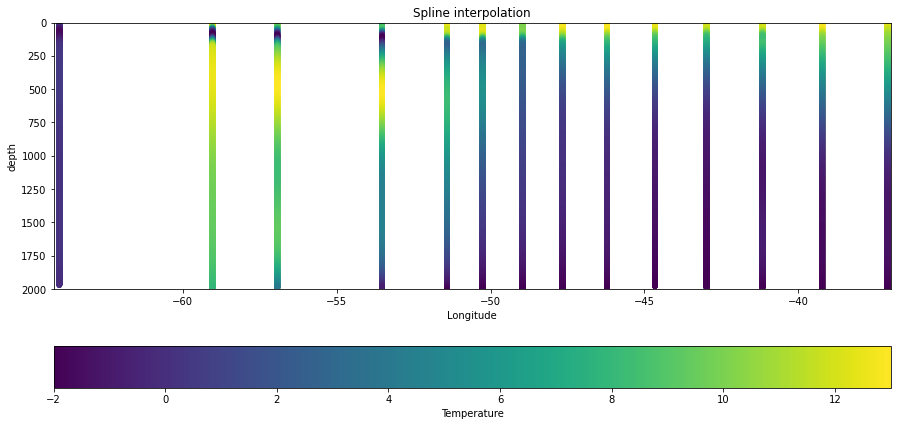

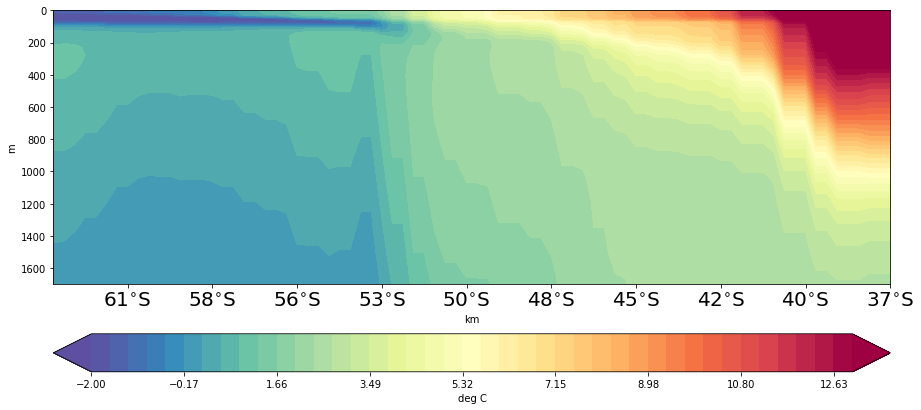

In [11]:
ax = plt.figure(figsize=(15,7))
for i in range(len(degE)):
    plt.scatter(np.matlib.repmat(degN[i], len(globals()["depthT_point_" + str(i)]),1), globals()["depthT_point_" + str(i)], 20,
                c=globals()["T_point_" + str(i)])
plt.title('Spline interpolation')
plt.xlabel("Longitude")
plt.ylabel("depth")
plt.ylim([2000, 0])
plt.xlim([-64.2, -37])
cbar= plt.colorbar(orientation='horizontal')
plt.clim(-2,13)
cbar.set_label("Temperature")
plt.show()

fig, ax = plt.subplots(1,1, figsize=(15,7))
image = pf.plot_transect(data, mesh, 
                         lon_start,
                         lat_start,
                         lon_end,
                         lat_end,
                         npoints=npoints,
                         levels = np.round(np.linspace(-2, 13, 42),2),
                         cmap=cm.Spectral_r,
                         maxdepth =2000,
                         title = '',
                         ncols=1,
                         figsize=(5,10),
                        ax = ax
                        )
cb = fig.colorbar(image, orientation='horizontal', ax=ax, pad=0.13)
cb.set_label('deg C')
ax.xaxis.set_ticks(dist[7::8])
ax.set_xticklabels(labeles, size=20);

### T, S trend (for every level and point)

In [12]:
# degN[0], degE[0], level 0

# EN4 data
data_list = []
for year in range(7,17):
    if year < 10:
        year = '0'+str(year)
    for month in range(1,13):
        if month < 10:
            month = '0'+str(month)
        en4 = Dataset('/home/najona/EN.4.2.0.profiles.g10.20' +str(year)+ '/EN.4.2.0.f.profiles.g10.20' +str(year)+str(month)+ '.nc')

        T = en4.variables['TEMP'][:]               # temperature [degC]
        PSAL = en4.variables['PSAL_CORRECTED'][:]  # practical salinity
        depth = en4.variables['DEPH_CORRECTED'][:] # depth [m]
        lat = en4.variables['LATITUDE'][:]
        long = en4.variables['LONGITUDE'][:]

        # julian day of the profile (JULD:units = "days since 1950-01-01 00:00:00 UTC")
        t = en4.variables['JULD'][:]
        date_ref = datetime.datetime.strptime('1950-01-01 00:00:00', "%Y-%m-%d %H:%M:%S")
        jd_ref = julian.to_jd(date_ref, fmt='jd')
        time = np.array([julian.from_jd(t[i] + jd_ref) for i in range(len(t))])

        min_1 = np.where(np.abs(long-degN[0]) < 3)
        min_2 = np.where(np.abs(lat-degE[0]) < 3)

        x = list(set(min_1[0].tolist()).intersection(min_2[0].tolist()))

        d = []
        for i in range(len(x)):
            d.append(distance.distance((degN[0], degE[0]), (long[x[i]], lat[x[i]])))

        data_monthly = ['20'+str(year), month, np.min(d), long[x[np.argmin(d)]], lat[x[np.argmin(d)]], T[x[np.argmin(d)],0],
                        depth[x[np.argmin(d)],0], time[x[np.argmin(d)]], PSAL[x[np.argmin(d)],0]]
        data_list = np.append(data_list, data_monthly)


In [13]:
data_list = data_list.reshape(120,9)

/home/najona/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Warning: converting a masked element to nan.
  
/home/najona/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Warning: converting a masked element to nan.
  import sys
/home/najona/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Warning: converting a masked element to nan.


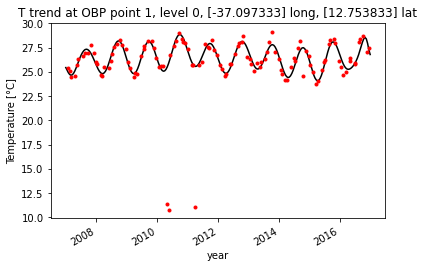

/home/najona/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


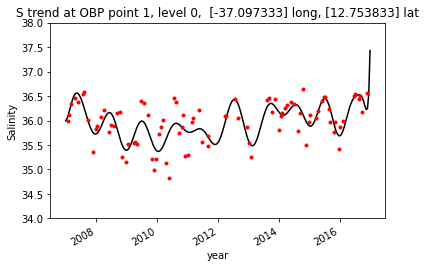

In [33]:
# Trend, annual and semi-annual signal

med_T = np.nanmedian(data_list[:,5].astype(float))
idx_T = np.where(abs(data_list[:,5].astype(float)- med_T) < 5)

med_S = np.nanmedian(data_list[:,-1].astype(float))
idx_S = np.where(abs(data_list[:,-1].astype(float)- med_S) < 5)

w = 2*math.pi/365 # frequency
p = 26            # degree of the harmonic function
p_S = 22

t = np.arange(1,121)
A_harm_T = func.getA_harm(t[idx_T], w, p)
A_harm_S = func.getA_harm(t[idx_S], w, p_S)
xS_harm_T,lS_harm_T,v_harm_T,rp_harm_T = func.linearGMM(A_harm_T, data_list[:,5].astype(float)[idx_T])
xS_harm_S,lS_harm_S,v_harm_S,rp_harm_S = func.linearGMM(A_harm_S, data_list[:,-1].astype(float)[idx_S])

abstand = 0.5
x_Raster = np.arange(1, 120, abstand)
Ax = func.getA_harm(x_Raster, w, p)
Ax_S = func.getA_harm(x_Raster, w, p_S)
f_Raster_T = Ax.dot(xS_harm_T)
f_Raster_S = Ax_S.dot(xS_harm_S)

base = datetime.datetime(2007, 1, 1)
arr = numpy.array([base + datetime.timedelta(days=15.4135*i) for i in range(len(x_Raster))])

plt.figure()
plt.title('T trend at OBP point 1, level 0, ' + str(degN[0])+ ' long, ' + str(degE[0]) + ' lat')
plt.plot(arr, f_Raster_T, 'k')
plt.plot(data_list[:,-2], data_list[:,5], 'r.')
plt.xlabel("year")
plt.ylabel("Temperature [°C]")
plt.gcf().autofmt_xdate()
plt.show()

plt.figure()
plt.title('S trend at OBP point 1, level 0,  ' + str(degN[0])+ ' long, ' + str(degE[0]) + ' lat')
plt.plot(arr, f_Raster_S, 'k')
plt.plot(data_list[:,-2], data_list[:,-1], 'r.')
plt.xlabel("year")
plt.ylabel("Salinity")
plt.ylim([34, 38])
plt.gcf().autofmt_xdate()
plt.show()